In [30]:
from PIL import Image
import h5py as h5 
import numpy as np
import imageio

In [31]:
file = h5.File('epfl3.h5','r')

In [37]:
print("What is in file['0']?",file['0'].keys())
data_0frame = file['0/frame']
print(data_0frame)
print(data_0frame.name)
array = data_0frame[0,...]
print("Shape and dtype of data_0frame[0,...] ::",array.shape, array.dtype)
#Max projection onto 2d surface (from 112x112x32 to 112x112)
test = np.max(array,axis=2)
print("Shape and dtype of np.max(data_0frame[0,...]) ::",test.shape, test.dtype)
img = Image.fromarray(test)
img.show()

What is in file['0']? <KeysViewHDF5 ['frame', 'mask']>
<HDF5 dataset "frame": shape (1, 112, 112, 32), type "<i2">
/0/frame
Shape and dtype of data_0frame[0,...] :: (112, 112, 32) int16
Shape and dtype of np.max(data_0frame[0,...]) :: (112, 112) int16


In [4]:
#Get all the foldernames (numbers)
ls = list(file.keys())
print("before sorting:", ls[0:5])
#Sort them as ints
ls.sort(key=int)
print("after sorting:",ls[0:5])

before sorting: ['0', '1', '10', '100', '1000']
after sorting: ['0', '1', '2', '3', '4']


In [8]:
#Getting an array for all images
PATH = '../misc/max_projected/'
ext = '.tif'

all_frames = np.empty((len(ls),112,112,32),dtype=np.int16)
for index, folder in enumerate(ls):
    #Extracting all frames
    name = folder+'/frame'
    frame = file[name]
    all_frames[index,...] = frame[0,...]
    #test = np.max(frame[0,...], axis = 2)
    #img = Image.fromarray(test)
    #img.save(PATH+str(index)+ext)
max_projected_images = np.max(all_frames[...],axis=3)
print(max_projected_images.shape)

(1715, 112, 112)


In [9]:
#small checks
print(all_frames[14,:,:,:].shape, all_frames[14,:,:,:].dtype)
np.max(all_frames[...],axis=3).shape

(112, 112, 32) int16


(1715, 112, 112)

In [33]:
PATH = '../misc/max_projected/frame_'
ext = '.png'
#trying to extract all images using max_projection, saving using imageio.
#Make sure you have created a directory to save the imgs to (check PATH)
for index, folder in enumerate(ls):
    foldername = folder+'/frame'
    filename = PATH+str(index)+ext
    imageio.imwrite(filename, np.max(file[foldername][0,...],axis=2))
    

Lossy conversion from int16 to uint8. Range [106, 247]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [106, 251]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [106, 252]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [106, 252]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [106, 251]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [106, 250]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [106, 251]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [106, 252]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to u

## Applying the Model 
(trained on Car images .... lol)


In [11]:
from __future__ import print_function, division
import os
import argparse
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from model.cnn_geometric_model import CNNGeometric
from data.pf_dataset import PFDataset
from data.download_datasets import download_PF_willow
from image.normalization import NormalizeImageDict, normalize_image
from util.torch_util import BatchTensorToVars, str_to_bool
from geotnf.transformation import GeometricTnf
from geotnf.point_tnf import *
import matplotlib.pyplot as plt
from skimage import io
import warnings
from torchvision.transforms import Normalize
from collections import OrderedDict

warnings.filterwarnings('ignore')

In [13]:
#Can be 'vgg' or 'resnet101'
model_aff_path = 'trained_models/base/aff-pascal-vgg/best_aff-pascal-vgg_affine_grid_lossvgg.pth.tar'
model_tps_path = 'trained_models/base/bestResnet101/best_checkpoint_adam_tps_grid_lossresnet101.pth.tar'
model_hom_path = ''

In [14]:
use_cuda = torch.cuda.is_available()
do_aff = not model_aff_path==''
do_tps = not model_tps_path==''
do_hom = not model_hom_path==''

# Create model
print('Creating CNN model...')

# CREATING MO
if do_aff:
    model_aff = CNNGeometric(output_dim=6,use_cuda=use_cuda,
                             feature_extraction_cnn='vgg')
if do_tps:
    model_tps = CNNGeometric(output_dim=18,use_cuda=use_cuda,
                             feature_extraction_cnn='resnet101')
#if do_hom:
#    if four_points:
#        model_hom = CNNGeometric(output_dim=8, use_cuda=use_cuda,
#                                feature_extraction_cnn=feature_extraction_cnn)
#    else : 
#        model_hom = CNNGeometric(output_dim=9, use_cuda=use_cuda,
#                        feature_extraction_cnn=feature_extraction_cnn)
# Load trained weights, not much to understand here, it's just that this is how it works.
print('Loading trained model weights...')
if do_aff:
    checkpoint = torch.load(model_aff_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_aff.load_state_dict(checkpoint['state_dict'])
    print('aff done')
if do_tps:
    checkpoint = torch.load(model_tps_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('resnet', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_tps.load_state_dict(checkpoint['state_dict'])
    print('tps done')

#Once again, while I wrote these lines, there is no model_homo_path trained so this is just for modularity
#if do_hom:
#    checkpoint = torch.load(model_hom_path, map_location=lambda storage, loc: storage)
#    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
#    model_hom.load_state_dict(checkpoint['state_dict'])

Creating CNN model...
Loading trained model weights...
aff done
tps done


In [15]:
tpsTnf = GeometricTnf(geometric_model='tps', use_cuda=use_cuda)
affTnf = GeometricTnf(geometric_model='affine', use_cuda=use_cuda)
homTnf = GeometricTnf(geometric_model='hom', use_cuda=use_cuda)

In [17]:
#Here resizes to 240x240 with bi-linear sampling
resizeCNN = GeometricTnf(out_h=240, out_w=240, use_cuda = False) 

def alt_preprocess_image(image,means,stds):
    """
    CALLED alt_preprocess_image because it differs a little bit from the one provided in the demo notebook
    """
    # convert to torch Variable
    image = np.expand_dims(image.transpose((2,0,1)),0)
    image = torch.Tensor(image.astype(np.float32)/255.0)
    image_var = Variable(image,requires_grad=False)
    # Resize image using bilinear sampling with identity affine tnf
    image_var = resizeCNN(image_var)
    # Normalize image
    image_var = normalize_image(image_var,mean=means,std=stds)
    return image_var

normalizeTnf = Normalize(mean = means, std=stds)

In [24]:
source = '../misc/max_projected/imageio_pngs/frame_787.png'
target = '../misc/max_projected/imageio_pngs/frame_794.png'
source_test = io.imread(source)
target_test = io.imread(target)
source_stacked = np.stack((source_test,)*3, axis=-1)
target_stacked = np.stack((target_test,)*3, axis=-1)


In [44]:
def apply_pair(source,target):
    #Redundant, reloads the image
    source_test = io.imread(source)
    target_test = io.imread(target)
    source_image = np.stack((source_test,)*3, axis=-1)
    target_image = np.stack((target_test,)*3, axis=-1)

    image_tmp = torch.Tensor(target_image.astype(np.float32)/255.0)
    #Getting means/stds
    R_mean, R_std = image_tmp[:,:,0].mean(), image_tmp[:,:,0].std()
    G_mean, G_std = image_tmp[:,:,1].mean(), image_tmp[:,:,1].std()
    B_mean, B_std = image_tmp[:,:,2].mean(), image_tmp[:,:,2].std()
    means = [R_mean, G_mean, B_mean]
    stds = [R_std, G_std, B_std]
    means=[0.485, 0.456, 0.406]
    stds=[0.229, 0.224, 0.225]
    #Use the preprocess method declared above to resize, normalize using the means and std computed above
    source_image_var = alt_preprocess_image(source_image,means=means, stds=stds)
    target_image_var = alt_preprocess_image(target_image,means=means, stds=stds)
    
    if use_cuda:
        source_image_var = source_image_var.cuda()
        target_image_var = target_image_var.cuda()
    #Create a "batch" (i.e. a pair) for the next cell below
    batch = {'source_image': source_image_var, 'target_image':target_image_var}
    #Resize target: create a function that will resize a given input into the target_image's dimension
    resizeTgt = GeometricTnf(out_h=target_image.shape[0], out_w=target_image.shape[1], use_cuda = use_cuda) 
    #Set the models to eval mode
    if do_aff:
        model_aff.eval()
    if do_tps:
        model_tps.eval()
    if do_hom:
        model_hom.eval()
        
    # Evaluate models and get the thetas
    if do_aff:
        theta_aff=model_aff(batch)
        warped_image_aff = affTnf(batch['source_image'],theta_aff.view(-1,2,3))
    
    if do_tps:
        theta_tps=model_tps(batch)
        warped_image_tps = tpsTnf(batch['source_image'],theta_tps)
    
    if do_aff and do_tps:
        theta_aff_tps=model_tps({'source_image': warped_image_aff, 'target_image': batch['target_image']})        
        warped_image_aff_tps = tpsTnf(warped_image_aff,theta_aff_tps)
    if do_aff:
        warped_image_aff_np = normalize_image(resizeTgt(warped_image_aff),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    
    if do_tps:
        warped_image_tps_np = normalize_image(resizeTgt(warped_image_tps),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    
    if do_aff and do_tps:
        warped_image_aff_tps_np = normalize_image(resizeTgt(warped_image_aff_tps),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()
    N_subplots = 2+int(do_aff)+int(do_tps)+int(do_aff and do_tps)
    fig, axs = plt.subplots(1,N_subplots)
    axs[0].imshow(source_image)
    axs[0].set_title('src')
    axs[1].imshow(target_image)
    axs[1].set_title('tgt')
    subplot_idx = 2
    if do_aff:
        axs[subplot_idx].imshow(warped_image_aff_np)
        axs[subplot_idx].set_title('aff')
        subplot_idx +=1 
    if do_tps:
        axs[subplot_idx].imshow(warped_image_tps_np)
        axs[subplot_idx].set_title('tps')
        subplot_idx +=1 
    if do_aff and do_tps:
        axs[subplot_idx].imshow(warped_image_aff_tps_np)
        axs[subplot_idx].set_title('aff+tps')
    
    for i in range(N_subplots):
        axs[i].axis('off')
    
    fig.set_dpi(330)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


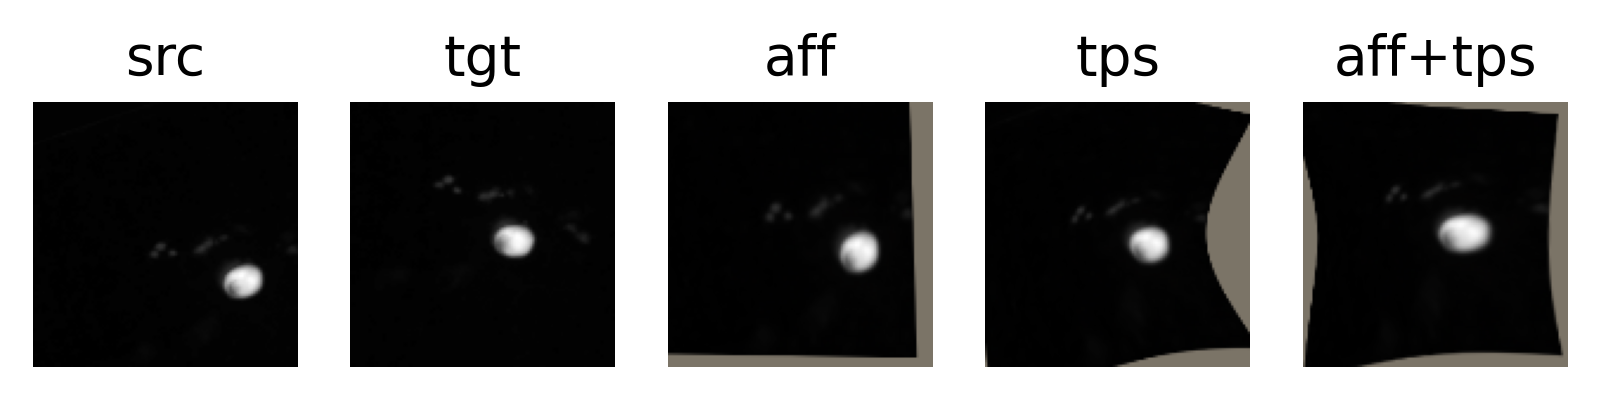

In [45]:
apply_pair(source,target)

In [ ]:
apply_pair(source,target)